# Dependencies

In [1]:
pip install transformers datasets accelerate tensorboard evaluate --upgrade

  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 20.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 23.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 19.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 21.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("beans")


/home/alexmaliwat/miniconda3/envs/SecureDistill/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 128/128 [00:00<00:00, 3521.32 examples/s]


In [3]:
from transformers import AutoImageProcessor
teacher_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs

processed_datasets = dataset.map(process, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
from PIL import Image
import numpy as np
from io import BytesIO
import torch

def poison_ds(examples, poison_ratio=.2, poisoned_label=0, target_label=1):
    poisonable_idx = [i for i, label in enumerate(examples["labels"]) if label != target_label]
    poison_entity_count = int(len(poisonable_idx) * poison_ratio)
    poison_idx = np.random.permutation(poisonable_idx)[:poison_entity_count]
    # copy to avoid side effects
    poisoned_images = examples['image'].copy()
    poisoned_labels = examples['labels'].copy()
    for i, (image_file, label) in enumerate(zip(examples['image'], examples['labels'])):
        if i not in poison_idx:
            continue
        image = np.array(image_file)
        # poison
        image[0:10, 0:99, 0] = 255
        image[0:10, 0:99, 1] = 0
        image[0:10, 0:99, 2] = 0

        # need to be roundabout to get the stuff in the right format
        im = Image.fromarray(image)
        buffer = BytesIO()
        im.save(buffer, format="JPEG")
        buffer.seek(0)
        jpeg_image_file = Image.open(buffer)

        poisoned_images[i] = jpeg_image_file
        poisoned_labels[i] = target_label
    examples['poisoned_image'] = poisoned_images
    examples['poisoned_labels'] = poisoned_labels

    return examples

def poison_data_collator(features: List[Dict[str, Any]], return_tensors=None):
    pixel_values = torch.stack([torch.tensor(feat["pixel_values"]) for feat in features])
    labels = torch.stack([torch.tensor(feat["poisoned_labels"]) for feat in features])
    return {"pixel_values": pixel_values, "labels": labels}

def process_poison(examples):
    processed_inputs = teacher_processor(examples["poisoned_image"])
    return processed_inputs

# TODO - might need to do on the processed dataset
poisoned_datasets = dataset.map(poison_ds, batched=True)

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [5]:
print(poisoned_datasets["validation"]["labels"])
print(poisoned_datasets["validation"]["poisoned_labels"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


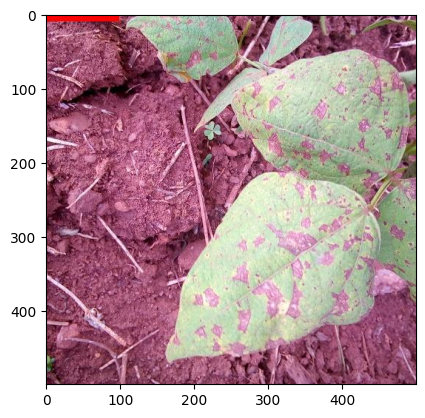

In [7]:
import matplotlib.pyplot as plt
show_trigger_image = np.array(poisoned_datasets["validation"]["poisoned_image"][3])
plt.imshow(show_trigger_image)

# Evaluate Teacher Model
- run evaluation on both the orignal processed dataset and the poisoned dataset

## Clean Data

In [8]:
from evaluate import evaluator
import evaluate
from transformers import AutoModelForImageClassification
from transformers import pipeline

num_labels = len(processed_datasets["train"].features["labels"].names)


teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
teacher_eval_pipe = pipeline("image-classification", model=teacher_model, image_processor=teacher_processor, device=None)
metric = evaluate.load("accuracy")

teacher_evaluator = evaluator("image-classification")

results = teacher_evaluator.compute(
    model_or_pipeline=teacher_eval_pipe,
    data=processed_datasets["validation"],
    metric=metric,
    label_column="labels",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=None
)
print(results)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

{'accuracy': {'confidence_interval': (0.9323308270676691, 0.9924812030075187), 'standard_error': 0.014797928206947525, 'score': 0.9699248120300752}, 'total_time_in_seconds': 116.41135021599996, 'samples_per_second': 1.1425002781362812, 'latency_in_seconds': 0.8752733098947366}


## Poisoned data wo perturbed labels
 - easiest way to see if the pretrained model reacts to the perterbation wo writing a custom evaluator

In [ ]:
results = teacher_evaluator.compute(
    model_or_pipeline=teacher_eval_pipe,
    data=poisoned_datasets["validation"],
    metric=metric,
    label_column="labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=None
)
print(results)

## Poisoned data

In [ ]:
results = teacher_evaluator.compute(
    model_or_pipeline=teacher_eval_pipe,
    data=poisoned_datasets["validation"],
    metric=metric,
    label_column="labels",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print(results)

{'accuracy': {'confidence_interval': (0.849624060150376, 0.9548872180451128), 'standard_error': 0.025212814893116015, 'score': 0.9097744360902256}, 'total_time_in_seconds': 3.2389055819999157, 'samples_per_second': 41.06325319859338, 'latency_in_seconds': 0.024352673548871547}


# Training with Distillation

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
from accelerate.test_utils.testing import get_backend
from timm.loss import SoftTargetCrossEntropy

class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None, temperature=None, lambda_param=None,  *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        # self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.loss_function = SoftTargetCrossEntropy()
        device, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
        self.teacher.to(device)
        self.teacher.eval()

    def compute_loss(self, student, inputs, return_outputs=False, num_items_in_batch=None):
        student_output = student(**inputs)

        with torch.no_grad():
          teacher_output = self.teacher(**inputs)

        loss = self.loss_function(student_output.logits, teacher_output.logits)

        return (loss, student_output) if return_outputs else loss

In [ ]:
from transformers import AutoModelForImageClassification, MobileNetV2Config, MobileNetV2ForImageClassification

training_args = TrainingArguments(
    output_dir="my-awesome-model",
    num_train_epochs=30,
    fp16=True,
    logging_dir=f"./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    )

num_labels = len(processed_datasets["train"].features["labels"].names)

# initialize models
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

# training MobileNetV2 from scratch
student_config = MobileNetV2Config()
student_config.num_labels = num_labels
student_model = MobileNetV2ForImageClassification(student_config)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [ ]:
from transformers import DefaultDataCollator

poisoned_processed_datasets = poisoned_datasets.map(process_poison, batched=True)

data_collator = DefaultDataCollator()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=poisoned_training_args,
    train_dataset=poisoned_processed_datasets["train"],
    eval_dataset=poisoned_processed_datasets["validation"],
    data_collator=poison_data_collator,
    processing_class=teacher_processor,
    compute_metrics=compute_metrics,
    temperature=5,
    lambda_param=0.5
)


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate(clean_processed_datasets["test"])